In [1]:
import qiskit
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.compiler import transpile
qiskit.IBMQ.load_account()


from math import pi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


from sklearn.metrics import accuracy_score, recall_score, precision_score
from scipy.spatial import distance

from collections import ChainMap

import json
import time

In [2]:
def qhamdist_gate(n_features, n_auxilia, lite):
    """Circuit for Quantum Hamming distance calculation"""
    qrx = qiskit.QuantumRegister(n_features, 'x')
    qry = qiskit.QuantumRegister(n_features, 'y')
    qra = qiskit.QuantumRegister(n_auxilia, 'a')
    circ = qiskit.QuantumCircuit(qrx, qry, qra, name='QHamDist')

    # ecncoding
    circ.cx(qry, qrx)
    circ.barrier()
    
    # extraction
    if qra.size == 1:
        circ.h(qra)
        circ.crz(pi / n_features, qrx, qra)
        #circ.cu1(pi / n_features, qra, qrx)
        circ.h(qra)

    elif qra.size == 2:
        circ.h(qra[1])
        circ.crz(pi / n_features, qrx[2:], qra[1])
        circ.swap(qra[1], qra[0])
        circ.crz(pi / n_features, qrx[:2], qra[0])
        circ.h(qra[0])
        
    circ.barrier()

    # decoding
    if not lite:
        circ.cx(qry, qrx)
    
    return circ

In [3]:
def compile_stack(states):
    """Initialize stack from quantum states"""

    stack = np.zeros(2**len(states[0]))
    for state in states:
        stack[int(''.join(map(str, state)), 2)] = 1

    return stack / np.sqrt(stack.sum())

In [4]:
def circuit(x, y, maps, lite):
    """Create quantum circuit for hamming distance calculation"""
    nx, ny, n_features = x.shape[0], y.shape[0], x.shape[1]

    ## Initialize circuit
    qrx = qiskit.QuantumRegister(n_features, 'x')
    qry = qiskit.QuantumRegister(n_features, 'y')
    if not maps:
        qra = qiskit.QuantumRegister(1, 'a')
    else:
        qra = qiskit.QuantumRegister(len(maps[-1]), 'a')

    crx = qiskit.ClassicalRegister(qrx.size, 'crx')
    cry = qiskit.ClassicalRegister(qry.size, 'cry')
    cra = qiskit.ClassicalRegister(1, 'cra')

    circ = qiskit.QuantumCircuit(qrx, qry, qra, crx, cry, cra)

    xstate_stack = compile_stack(x.tolist())
    if xstate_stack.all():
        circ.h(qrx)

    else:
        circ.initialize(compile_stack(x.tolist()), qrx)

    ystate_stack = compile_stack(y.tolist())
    if ystate_stack.all():
        circ.h(qry)

    else:
        circ.initialize(compile_stack(y.tolist()), qry)
    
    
    # Hamming distance gate
    circ.append(
        qhamdist_gate(n_features, n_auxilia=qra.size, lite=lite),
        list(qrx) + list(qry) + list(qra)
    )


    ## Measurement
    if not lite:
        circ.measure(qrx, crx)

    circ.measure(qry, cry)
    circ.measure(qra[:1], cra)

    if maps:
        layout = dict(
            ChainMap(
                *({r[i]: v for i, v in enumerate(map_)}
                  for r, map_ in zip([qrx, qry, qra], maps))
            )
        )
        provider = qiskit.IBMQ.get_provider(hub='ibm-q')
        device = provider.get_backend('ibmq_16_melbourne')
        circ = transpile(circ, device, initial_layout=layout)
    
    return circ

In [5]:
def execute(circ, backend, shots):
    """Execute job"""
    
    if not backend:
        device = qiskit.BasicAer.get_backend('qasm_simulator')
        job = qiskit.execute(circ, device, shots=shots)

    else:
        provider = qiskit.IBMQ.get_provider(hub='ibm-q')
        device = provider.get_backend('ibmq_16_melbourne')

        
        if backend == 'ibmq':
            job = qiskit.execute(circ, device, shots=shots, max_credits=1)
            job_monitor(job)

        elif backend == 'noise':
            coupling_map = device.configuration().coupling_map
            noise_model = NoiseModel.from_backend(device)
            basis_gates = noise_model.basis_gates

            device = qiskit.Aer.get_backend('qasm_simulator')
            job = qiskit.execute(
                circ, device, shots=shots,
                coupling_map=coupling_map,
                noise_model=noise_model,
                basis_gates=basis_gates
            )
    
    result = job.result()
    counts = result.get_counts()
    
    if backend == 'ibmq':
        with open(f'.ibmq_counts_n{n_features}_{int(time.time())}.json', 'w') as f:
            json.dump(counts, f)
            
            
    return counts

In [6]:
def process(x, y, counts, lite):
    """Process counts average amplitudes"""
    nx, ny, n_features = x.shape[0], y.shape[0], x.shape[1]
    
    ampl = np.zeros((nx, ny, 2))
    shots = sum(v for _, v in counts.items())
    noise_shots = 0

    xstates = {''.join(x[i].astype(str)): i for i in range(x.shape[0])}
    ystates = {''.join(y[i].astype(str)): i for i in range(y.shape[0])}
    astates = {'0': 0, '1': 1}

    #print(result.get_counts())
    for state, count in counts.items():
        astate, ystate, xstate = state.split()

        if lite:
            xstate = ''.join(x.flatten().astype(str))

        if astate in astates and xstate in xstates and ystate in ystates:
            ampl[xstates[xstate], ystates[ystate], astates[astate]] = count

        else:
            noise_shots += count
            #print(f'Excess state {state} with count {count}')


    if noise_shots:
        print(f'Noise shouts {noise_shots} form {shots}')

    ## Averaging
    ampl /= (shots - noise_shots)
    ampl *= (nx * ny)
    np.clip(ampl, 0, 1, out=ampl)
    return ((ampl[:, :, 0] + (1 - ampl[:, :, 1])) / 2)

In [7]:
def qhamdist(x, y, backend=None, shots=None, maps=None):
    """Hamming distance calculation between `x` and `y`.

    Args:
        x: ndarray with shape (n_samples, n_features)
        y: ndarray with shape (m_samples, n_features)
        backend {'noise', 'ibmq'}: backend for execution.
        maps (list of list):  map registers to fix qubits

    Return ndarray with shape (n_samples, m_samples)
    """

    if len(x.shape) == 1 or len(y.shape) == 1:
        raise ValueError(
            'Invalid shape.'
            'Use reshape(1, -1) for passing one dimension array.'
        )

    if x.shape[1] != y.shape[1]:
        raise ValueError('Number of features is difference')

    # checking if lite circuit is possible  
    if x.shape[0] == 1 or y.shape[0] == 1:
        lite = True
        logging.warning('Compose cirquit in lite mode')
        if y.shape[0] == 1:
            x, y = y, x

    else:
        lite = False

    # Create circuit
    circ = circuit(x, y, maps, lite)
    
    
    # Set shots
    shots = shots or 20 * x.shape[0] * y.shape[0]
    shots = shots if shots < 8000 else 8000
    print(shots)
    
    # Execution 
    counts = execute(circ, backend, shots)
    
    # Process
    return process(x, y, counts, lite)

In [8]:
def heatmap(ax, mat, ylabels, xlabels, annotation=None, title=None, palette=None):
    
    if palette:
        ax.imshow(palette[mat], origin='lower', cmap='gray')
    
    else:
        ax.imshow(mat, origin='lower', cmap='gray')

    ax.set_xticks(range(0, len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=90, fontsize='20');
    ax.set_yticks(range(0, len(ylabels)))
    ax.set_yticklabels(ylabels, fontsize='20');
    ax.set_title(title or 'Distance matrix', fontsize='20')
    
    if annotation is not None:
        for i in range(annotation.shape[0]):
            for j in range(annotation.shape[1]):
                ax.text(j, i, annotation[i, j],
                        ha="center", va="center", color="#FF0000", fontsize='20') # "#05445E"

In [9]:
def full_superposition(n):
    return [list(map(int, bin(i)[2:].zfill(n))) for i in range(2**n)]

### Distance matrix

#### Review

In [10]:
#x = np.array([[0, 0, 0], [0, 1, 1]])
#y = np.array([[0, 0, 0], [0, 1 ,0], [1, 0, 0]])

n = 3
x = y =  np.array(full_superposition(n))

xlabels = [''.join(map(str, x_)) for x_ in x]
ylabels = [''.join(map(str, y_)) for y_ in y]

if n == 3:
    #maps = [[4, 9, 6], [3, 10, 8], [5]] 
    #maps = [[12, 3, 10], [13, 4, 9], [11]]
    #maps = [[1, 12, 3], [0, 11, 4], [2]]
    maps = [[11, 4, 9], [12, 3, 8], [10]] 

elif n == 4:
    maps = [[1, 3, 11, 13], [0, 4, 10, 14], [2, 12]]

#ampl = qhamdist(x, y)
ampl = qhamdist(x, y, maps=maps, backend='noise')

1280


Accuracy: 0.83
Recall: 0.84
Precision: 0.82


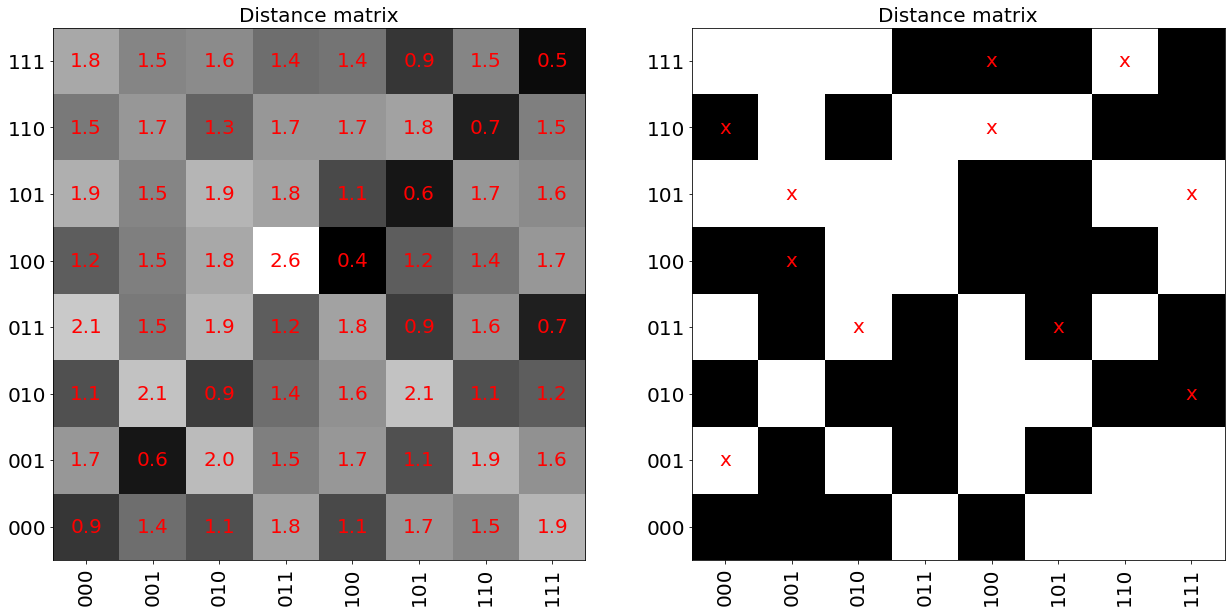

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(21, 10))

hamdist = np.arccos(np.sqrt(ampl)) * 2 * x.shape[1] / pi
heatmap(axes[0], hamdist, xlabels, ylabels, annotation=hamdist.round(1))


limit = 1.5
calc_neighbors = hamdist > limit 
true_neighbors = distance.cdist(x, y, metric='hamming') * x.shape[1] > limit

errors = np.array([[' '] * x.shape[0] for _ in range(y.shape[0])])
errors[true_neighbors != calc_neighbors] = 'x'
tp = (true_neighbors * calc_neighbors)
fp = true_neighbors * (true_neighbors != calc_neighbors)

print(f"Accuracy: {accuracy_score(true_neighbors.flatten(), calc_neighbors.flatten()).round(2)}")
print(f"Recall: {recall_score(true_neighbors.flatten(), calc_neighbors.flatten()).round(2)}")
print(f"Precision: {precision_score(true_neighbors.flatten(), calc_neighbors.flatten()).round(2)}")

heatmap(axes[1], calc_neighbors, xlabels, ylabels, annotation=errors)
plt.show()

#### Figure

### QCircuit

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


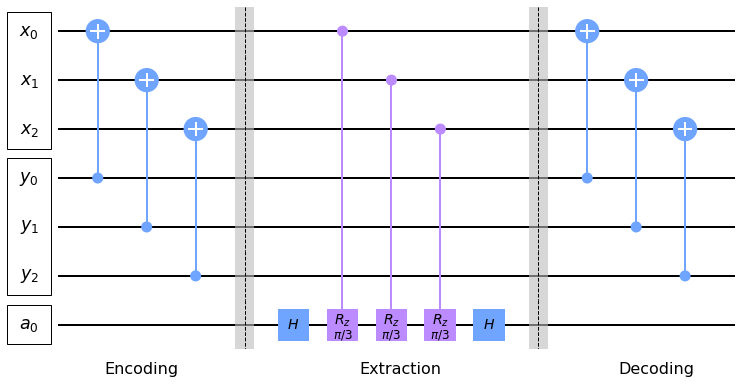

In [52]:
fig, ax = plt.subplots(1, 1)
ax.add_patch(Rectangle((-1, -2.4), 0.9, 2.8, edgecolor="k", facecolor="white"))
ax.add_patch(Rectangle((-1, -5.4), 0.9, 2.8, edgecolor="k", facecolor="white"))
ax.add_patch(Rectangle((-1, -6.4), 0.9, 0.8, edgecolor="k", facecolor="white"))

style={
    "fontsize": 14, 
    "subfontsize": 12, 
    "backgroundcolor": 'white', 
    'margin': [0.99, 0.3, 0, 0],
}
cicuit = qhamdist_gate(n_features=3, n_auxilia=1, lite=False)
cicuit.draw(ax=ax, style=style, output='mpl')

ax.text(1, -7, 'Encoding', fontsize=16)
ax.text(6.2, -7, 'Extraction', fontsize=16)
ax.text(11.5, -7, 'Decoding', fontsize=16)

#ax.text(-1.55, -1.2, 'X', fontsize=24)
#ax.text(-1.55, -4.2, 'Y', fontsize=24)
#ax.text(-1.55, -6.15, 'a', fontsize=24)

fig.set_facecolor('white')
fig.savefig('qcircuit.eps', bbox_inches='tight')